# Analysis of temporal clustering

Recall order can be affected by many influences, including temporal contiguity, stimulus category, and semantic clustering. Multiple methods exist for measuring each of these influences. Making matters more complicated, measuring different factors may require controlling for other factors.

Here, we'll focus on temporal clustering while controlling for stimulus category. As in prior tutorials, we will examine the dataset of Morton et al. (2013), where participants recalled from lists composed of celebrities, landmarks, and objects.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from psifr import fr

In [2]:
raw = fr.sample_data("Morton2013")
raw["category"] = raw["category"].astype("category").cat.as_ordered()
data = fr.merge_free_recall(
    raw, list_keys=["list_type", "list_category"], study_keys=["category"]
)

## Temporal clustering

First, we'll use a conditional response probability by lag (lag-CRP) analysis to measure temporal clustering. We'll first examine the pure lists, which all contain items from the same category. The `lag_crp` function automatically excludes repeats (which are deemed invalid because they involve repeating previously recalled items) and intrusions (which are invalid because their input position is undefined).

In [3]:
pure = data.query("list_type == 'pure'")
crp = fr.lag_crp(pure)
crp

prob  actual  possible
subject lag                              
1       -23.0  0.000000       0        18
        -22.0  0.060606       2        33
        -21.0  0.045455       2        44
        -20.0  0.063830       3        47
        -19.0  0.000000       0        54
...                 ...     ...       ...
47       19.0  0.058824       1        17
         20.0  0.000000       0        14
         21.0  0.000000       0         9
         22.0  0.000000       0         4
         23.0  0.000000       0         2

[1880 rows x 3 columns]

Each row in the results corresponds to one lag bin for one subject. The columns give the number of times the participant actually made that transition (conditional on the transition not including a repeat of a previously recalled item), the number of times that transition was possible (conditional on the items not yet recalled), and the probability calculated by dividing actual by possible. If a transition was never possible, the probability will be `NaN`; this applies to lag zero, which by definition was never "possible" because repeated recalls are defined as invalid for the purpose of this analysis.

Next, we can visualize the results using `fr.plot_lag_crp`.

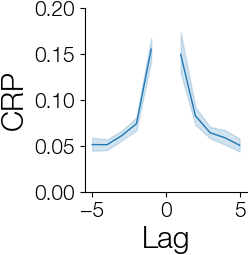

In [4]:
g = fr.plot_lag_crp(crp)
g.set(ylim=(0, .2));

### Excluding output positions

We can exclude intial output positions using the `item_query` option. This is a powerful mechanism that can be used to include only items that are relevant for a specific analysis. In this case, we'll specify a query string of `"output > 3"` to indicate that recalls with an output position of less than or equal to 3 should be excluded from the analysis. 

Items that weren't recalled are still valid possible items that could have been recalled. However, those items have no defined output position, so we must include them explicitly using `"or not recall"`. 

Under the hood, this uses `pandas.DataFrame.query`, so any query supported by that method is valid.

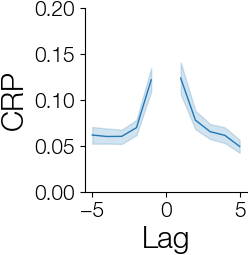

In [5]:
crp_op = fr.lag_crp(pure, item_query="output > 3 or not recall")
g = fr.plot_lag_crp(crp_op)
g.set(ylim=(0, .2));

### Temporal clustering as a function of category

As for calculating recall performance, we can use the filtering and grouping functionality of pandas to split the data up any way we want. For analysis of recall transitions, however, we must take care to keep entire recall sequences together. This ensures that, for example, transitions to and from an intrusion are excluded.

Here, we'll split lists by category using the `list_category` field. When running `merge_lists`, we specified that field as applying to all events in each list; this includes intrusions. Therefore, we can group by the `list_category` field and still keep the original recall sequence together even though intrusions have no defined category.

We can apply the analysis to multiple groups by combining `groupby` with `apply`, passing in the lag CRP function.

In [6]:
pure_crp_cat = pure.groupby(["list_category"]).apply(fr.lag_crp)
pure_crp_cat

prob  actual  possible
list_category subject lag                              
cel           1       -23.0  0.000000       0         6
                      -22.0  0.083333       1        12
                      -21.0  0.062500       1        16
                      -20.0  0.000000       0        16
                      -19.0  0.000000       0        18
...                               ...     ...       ...
obj           47       19.0  0.000000       0         4
                       20.0  0.000000       0         1
                       21.0  0.000000       0         1
                       22.0       NaN       0         0
                       23.0       NaN       0         0

[5640 rows x 3 columns]

We now have results of the analysis similar to before, but with an additional index of `list_category`. We can use this in a plot to quickly compare categories. The plotting functions in `psifr` support the same options as the Seaborn `relplot` function. Here, we set hue to `list_category` to plot each category as a different color.

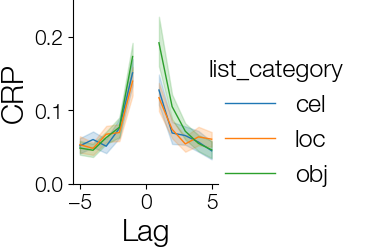

In [7]:
g = fr.plot_lag_crp(pure_crp_cat, hue="list_category")
g.add_legend()
g.set(ylim=(0, .25));

We can also quickly organize things in different ways. For example, we can instead plot category as different panels by setting the `col` parameter instead:

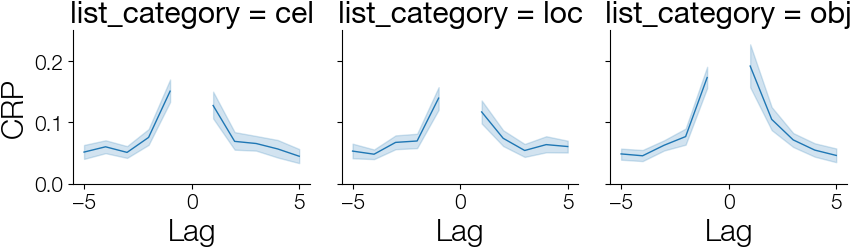

In [8]:
g = fr.plot_lag_crp(pure_crp_cat, col="list_category")
g.set(ylim=(0, .25));

## Filtering transitions

While the above methods allow us to quickly analyze groups of lists, in some cases we may want to focus on specific transitions. For example, in the mixed lists, items are grouped in category blocks. As participants tend to group together items from the same category during recall, this may cause temporal clustering to be artificially inflated. We can separate out temporal clustering from category clustering by analyzing within-category transitions and between-category transitions separately.

This involves two parts: (1) category labels for each item, here stored in the `category` field; and (2) a rule indicating whether to include a given transition, based on the category labels of the items involved.

The rule is indicated by a function that takes in the previous and current item labels and outputs a boolean value that is true for items that should be included. The function must be able to handle two cases: (1) if the `current` input is a scalar indicating the item that was actually recalled and (2) if the `current` input is an array indicating the set of possible items that could have been recalled. For example, if we just want to test if category labels for a transition were the same for the previous and current items, we can use a very simple function:

In [9]:
def same_category(x, y):
    return x == y

prev = "cel"
curr = "loc"
print(same_category(prev, curr))

curr = np.array(["cel", "loc", "obj", "loc"])
print(same_category(prev, curr))

False
[ True False False False]


If the function is passed a scalar for the `curr` item, it will return `True` or `False` depending on whether that comparison passes the test. If it gets passed an array, it will return a boolean array indicating if each item passes the test or not.

### Within-category transitions

We can also quickly define tests using anonymous lambda functions.

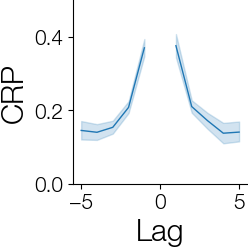

In [10]:
# get mixed lists
mixed = data.query("list_type == 'mixed'")

# only include transitions between items with the same category label
crp = fr.lag_crp(mixed, test_key="category", test=lambda x, y: x == y)
g = fr.plot_lag_crp(crp)
g.set(ylim=(0, .5));

### Between-category transitions

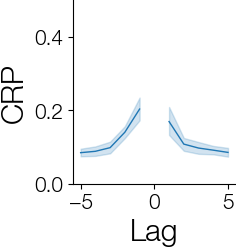

In [11]:
# only include transitions between items with different category labels
crp = fr.lag_crp(mixed, test_key="category", test=lambda x, y: x != y)
g = fr.plot_lag_crp(crp)
g.set(ylim=(0, .5));

### Within-category transitions separated by category

For each category, we'll test that both the item being transitioned from and the item being transitioned to are from that category.

In [12]:
categories = mixed["category"].cat.categories
cat_crp = [
    fr.lag_crp(mixed, item_query=f"category == '{category}'") 
    for category in categories
]
crp = pd.concat(cat_crp, keys=categories, axis=0)
crp.index = crp.index.set_names("category", level=0)

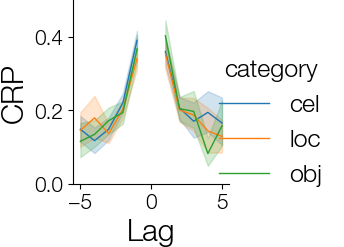

In [13]:
g = fr.plot_lag_crp(crp, hue='category')
g.add_legend()
g.set(ylim=(0, .5));

In [14]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

seaborn: 0.12.0
numpy  : 1.23.4
psifr  : 0.8.2
pandas : 1.5.0

